# MiloR differential abundance testing

In [1]:
# Load packages
suppressPackageStartupMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(SingleCellExperiment)
    library(scater)
    library(scran)
    library(edgeR)
    library(ggrastr)
    library(Seurat)
    library(miloR)
})

here::i_am("MiloR/01_Milo_analysis_manual.ipynb")

# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))
BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

set.seed(1234)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/12_Eomes_T_Mixl1/T/code



In [2]:
args = list()
args$sce = io$rna.sce
args$metadata = paste0(io$basedir, 'results/rna/mapping/manual/metadata_mapping_updated.txt.gz')
args$remove_ExE_cells = TRUE
args$batch_correction = "tdTom"
args$vars_to_regress = c('nFeature_RNA', 'nCount_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA')
args$features = 4000
args$npcs = 40
args$n_neighbors = 20
args$min_dist = 0.4
args$prop = 0.1
args$seed = 12345
args$outdir = paste0(io$basedir,"/results/rna/MiloR/manual/")
dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

# Dimensionality reduction

In [7]:
###############
## Load data ##
###############

# Load metadata
sample_metadata = fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE] %>%
   .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]

if (args$remove_ExE_cells) {
  print("Removing ExE cells...")
  sample_metadata = sample_metadata %>%
    .[!celltype.mapped_mnn%in%c("Visceral_endoderm","ExE_endoderm","ExE_ectoderm","Parietal_endoderm")]
}

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

[1] "Removing ExE cells..."


In [9]:
##############################
## Dimensionality Reduction ##
##############################

if (args$batch_correction %in% c('tdTom')) {
     source(here::here("mapping/run/mnn/mapping_functions.R"))
     library(batchelor)
   }

 if (length(args$vars_to_regress)>0) {
  stopifnot(args$vars_to_regress%in%colnames(sample_metadata))
 }

## Feature selection 

# Find HVGs - detection on WT samples only
# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol", "description")] %>%
  .[symbol!="" & ens_id%in%rownames(sce)] %>%
  .[!duplicated(symbol)]

# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]
# Other imprinted genes: 
#- Nnat (https://www.genecards.org/cgi-bin/carddisp.pl?gene=NNAT)
#- Grb10 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRB10)

genes_keep = rownames(sce)
genes_keep <- genes_keep[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes_keep,invert=T)] # filter out non-informative genes
genes_keep <- genes_keep[grep("^Hbb|^Hba",genes_keep,invert=T)] # test removing Haem genes 
genes_keep <- genes_keep[!genes_keep %in% c(imprint, 'Grb10', 'Nnat')] # remove imprinted genes
genes_keep <- genes_keep[!genes_keep %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes_keep <- genes_keep[!genes_keep == "tomato-td"] # remove tomato itself
genes_keep <- genes_keep[!genes_keep %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

sce_wt = sce[genes_keep, sample_metadata[tdTom==FALSE, cell]]
# Find variable genes using Seurat
hvgs = VariableFeatures(FindVariableFeatures(as.Seurat(sce_wt), nfeatures = args$features))

sce_filt <- sce[hvgs,]

In [10]:
## Regress out covariates 
 if (length(args$vars_to_regress)>0) {
   print(sprintf("Regressing out variables: %s", paste(args$vars_to_regress,collapse=" ")))
   logcounts(sce_filt) <- RegressOutMatrix(
     mtx = logcounts(sce_filt), 
     covariates = colData(sce_filt)[,args$vars_to_regress,drop=F]
   )
 }

[1] "Regressing out variables: nFeature_RNA nCount_RNA mitochondrial_percent_RNA ribosomal_percent_RNA"


In [11]:
# PCA and batch correction
if (args$batch_correction=='tdTom') {
    print('batch correcting by tdTom')
    pca <- multiBatchPCA(sce_filt, batch = colData(sce_filt)[[args$batch_correction]], d = args$npcs)
    pca.corrected <- reducedMNN(pca)$corrected
    colnames(pca.corrected) <- paste0("PC",1:ncol(pca.corrected))
    pca.corrected = pca.corrected[match(colnames(sce_filt), rownames(pca.corrected)),]
    reducedDim(sce_filt, "PCA") <- pca.corrected
 } else {
    print('PCA without batch correction')
    sce_filt <- runPCA(sce_filt, ncomponents = args$npcs, ntop=args$features)  
 }

[1] "batch correcting by tdTom"


In [12]:
 pca.dt <- reducedDim(sce_filt,"PCA") %>% round(3) %>% as.data.table(keep.rownames = T) %>% setnames("rn","cell")


In [13]:
fwrite(pca.dt, file.path(args$outdir, 'PCA.txt.gz'))

In [14]:
## UMAP
set.seed(args$seed)
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = args$n_neighbors, min_dist = args$min_dist)

# Fetch UMAP coordinates
umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

In [15]:
fwrite(umap.dt, file.path(args$outdir, 'UMAP.txt.gz'))

In [16]:
# plotting
to.plot <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
    .[,cell:=colnames(sce_filt)] %>%
    merge(sample_metadata, by="cell")

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


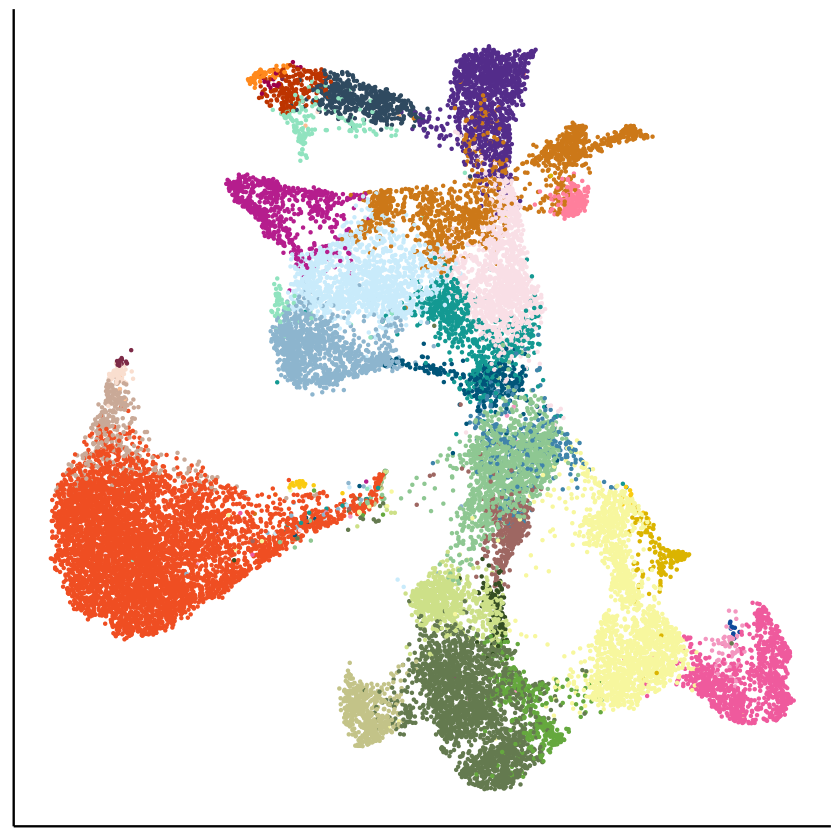

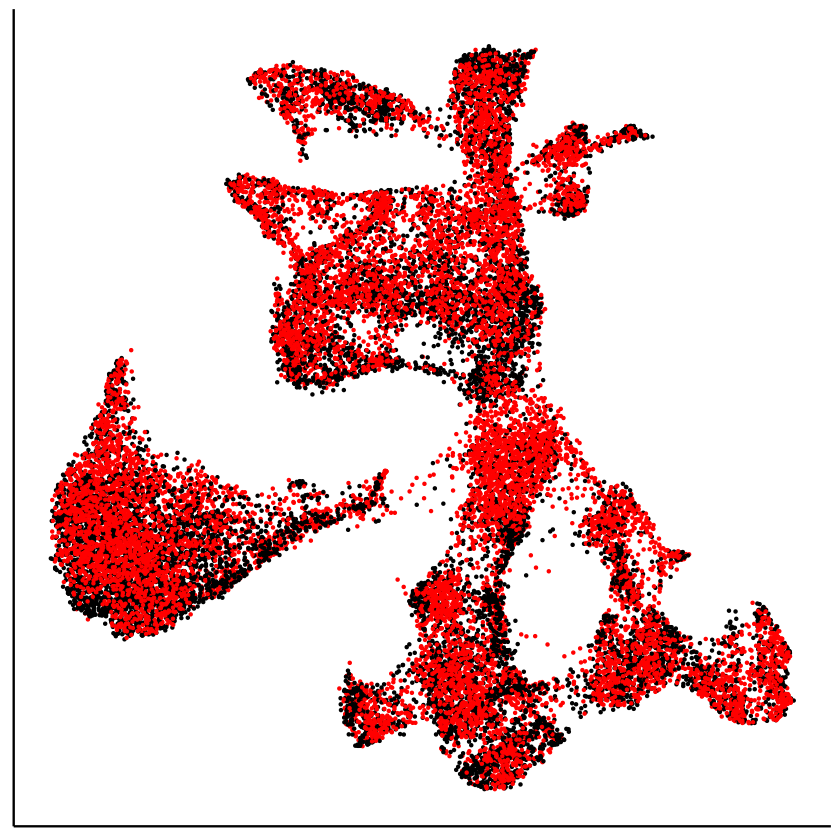

In [17]:
ggplot(to.plot, aes_string(x="V1", y="V2", col='celltype_updated')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

ggplot(to.plot, aes_string(x="V1", y="V2", col='tdTom')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=opts$tdTom.color) +
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

In [18]:
unique(to.plot$celltype_updated)

[1] "Allantois"                        "Forebrain_Midbrain_Hindbrain"    
 [3] "Erythroid"                        "Surface_ectoderm"                
 [5] "Blood_progenitors_1"              "Cardiomyocytes"                  
 [7] "Paraxial_mesoderm"                "Mesenchyme"                      
 [9] "Gut"                              "Pharyngeal_mesoderm"             
[11] "Blood_progenitors_2"              "Neural_crest"                    
[13] "Spinal_cord"                      "NMP"                             
[15] "YS_endothelium"                   "Embryo_proper_endothelium"       
[17] "Lateral_plate_mesoderm"           "Amniotic_ectoderm"               
[19] "Caudal_Mesoderm"                  "Intermediate_mesoderm"           
[21] "PGC"                              "YS_mesothelium"                  
[23] "Allantois_endothelium"            "Venous_endothelium"              
[25] "Endocardium"                      "Def._endoderm"                   
[27] "Caudal_epiblast"                  "Somitic_mesoderm"                
[29] "Rostral_neurectoderm"             "Caudal_neurectoderm"             
[31] "Notochord"                        "EMP"                             
[33] "Cardiopharyngeal_progenitors_SHF" "Haematoendothelial_progenitors"  
[35] "Nascent_mesoderm"

# MiloR

In [19]:
# Add PCA to SCE object
reducedDim(sce,"PCA") = reducedDim(sce_filt,"PCA")

# Add UMAP to SCE object
reducedDim(sce,"UMAP") = reducedDim(sce_filt,"UMAP")

# Add UMAP of Atlas to SCE object
umap.dt <- sample_metadata %>%
    .[,c("cell","umapX","umapY")]
umap = umap.dt[match(colnames(sce), cell)] %>% tibble::column_to_rownames("cell") %>% as.matrix
reducedDim(sce,"UMAP_atlas") = umap

In [38]:
# Milo arguments
args$prop = 0.1
args$n_neighbors = 40 # smaller --> smaller Nhoods --> higher resolution, but worse statistics


Constructing kNN graph with k:40

Checking valid object

Running refined sampling with reduced_dim



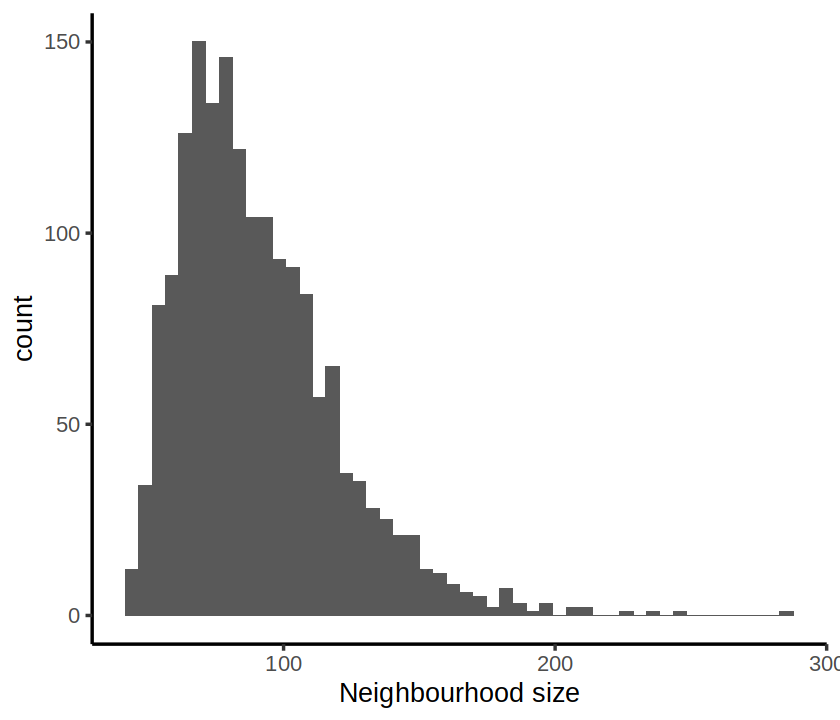

In [39]:
# create object
Milo_sce <- Milo(sce)

colData(Milo_sce)$sample_ko = paste0(colData(Milo_sce)$sample, '_',  colData(Milo_sce)$tdTom)

# Build graph
Milo_sce <- buildGraph(Milo_sce, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       reduced.dim = "PCA")

# Identify neighbourhoods from NN-cells
# lower prop for larger datasets
Milo_sce <- makeNhoods(Milo_sce, 
                       prop = args$prop, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       refined = TRUE, 
                       reduced_dims = "PCA")

options(repr.plot.width = 7, repr.plot.height=6)
plotNhoodSizeHist(Milo_sce)

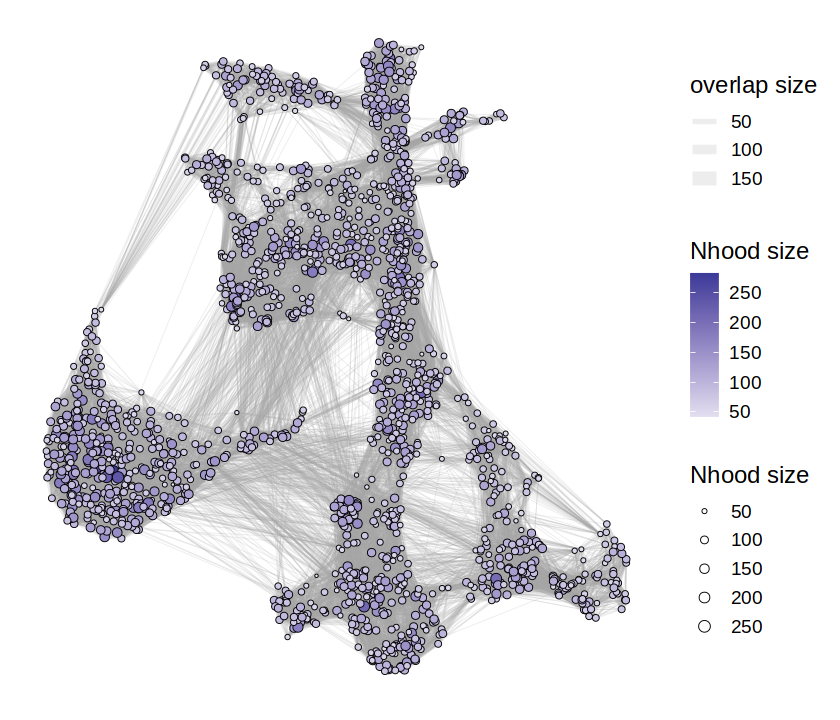

In [40]:
# Build neighbourhood graph
Milo_sce <- buildNhoodGraph(Milo_sce)
plotNhoodGraph(
  Milo_sce,
  layout = "UMAP")

In [41]:
Milo_sce

class: Milo 
dim: 27995 24414 
metadata(0):
assays(2): counts logcounts
rownames(27995): Xkr4 Gm1992 ... mt-Cytb tomato-td
rowData names(0):
colnames(24414): sample_1#TGATTTCTCACTGGGC sample_9#GTACTTTAGAGCAATT
  ... sample_10#GTGCTTCGTTAAAGAC sample_8#CCTATTACAAGAGTCG
colData names(25): closest.cell_mnn sample ... pool sample_ko
reducedDimNames(3): PCA UMAP UMAP_atlas
mainExpName: RNA
altExpNames(0):
nhoods dimensions(2): 24414 1725
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 1725
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 1725 1725

In [42]:
# count cells of different samples per neighbourhood
Milo_sce <- countCells(Milo_sce, meta.data = colData(Milo_sce),  samples = 'sample_ko')

# Calculate Neighbourhood Distances (most time consuming step)
Milo_sce <- calcNhoodDistance(Milo_sce, d=args$npcs, reduced.dim = "PCA")

# Build neighbourhood graph
#Milo_sce <- buildNhoodGraph(Milo_sce)

Checking meta.data validity

Counting cells in neighbourhoods



In [82]:
saveRDS(Milo_sce, file.path(args$outdir, 'Milo_sce.rds'))

In [43]:
# Embryo design table
embryo_design <- data.frame(colData(Milo_sce))[,c("sample_ko", "sample", 'tdTom', 'pool')]

embryo_design <- distinct(embryo_design)
rownames(embryo_design) <- embryo_design$sample_ko

# Test differential abundance per hood
da_results <- testNhoods(Milo_sce, design = ~ as.factor(pool) + tdTom, design.df = embryo_design, reduced.dim="PCA")

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [44]:
p1 = ggplot(da_results, aes(PValue)) + 
    geom_histogram(bins=50) + 
    theme_bw()

p2 = ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
    geom_point() +
    geom_hline(yintercept = 1) + ## Mark significance threshold (10% FDR)
    theme_bw()


## Plot single-cell UMAP
p3 = plotReducedDim(Milo_sce, dimred = "UMAP", colour_by="tdTom_corr", text_by = "celltype.mapped_mnn", 
                          text_size = 3, point_size=0.3, text_colour = "grey30") +
    scale_color_manual(values=opts$tdTom.color, name = 'tdTom') + 
    theme_void() + 
    theme(legend.position='right') +
    guides(fill="none")

## Plot neighbourhood graph
p4 = plotNhoodGraphDA(Milo_sce, da_results, layout="UMAP",alpha=0.05) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


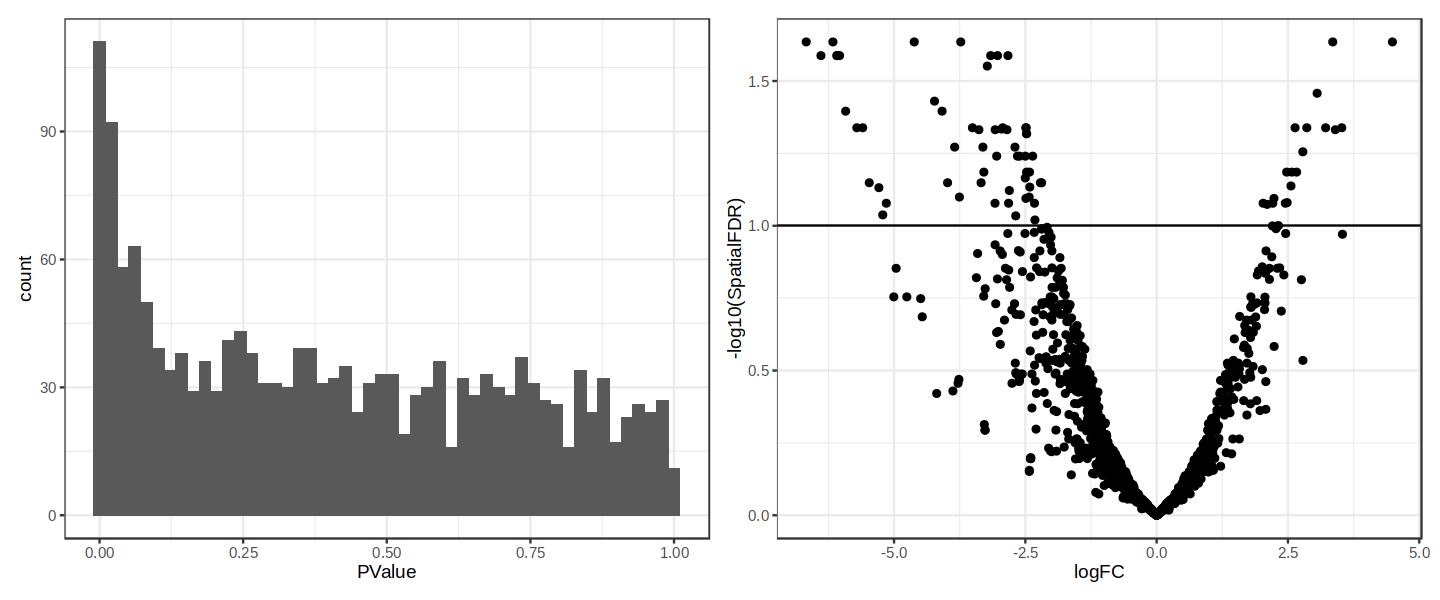

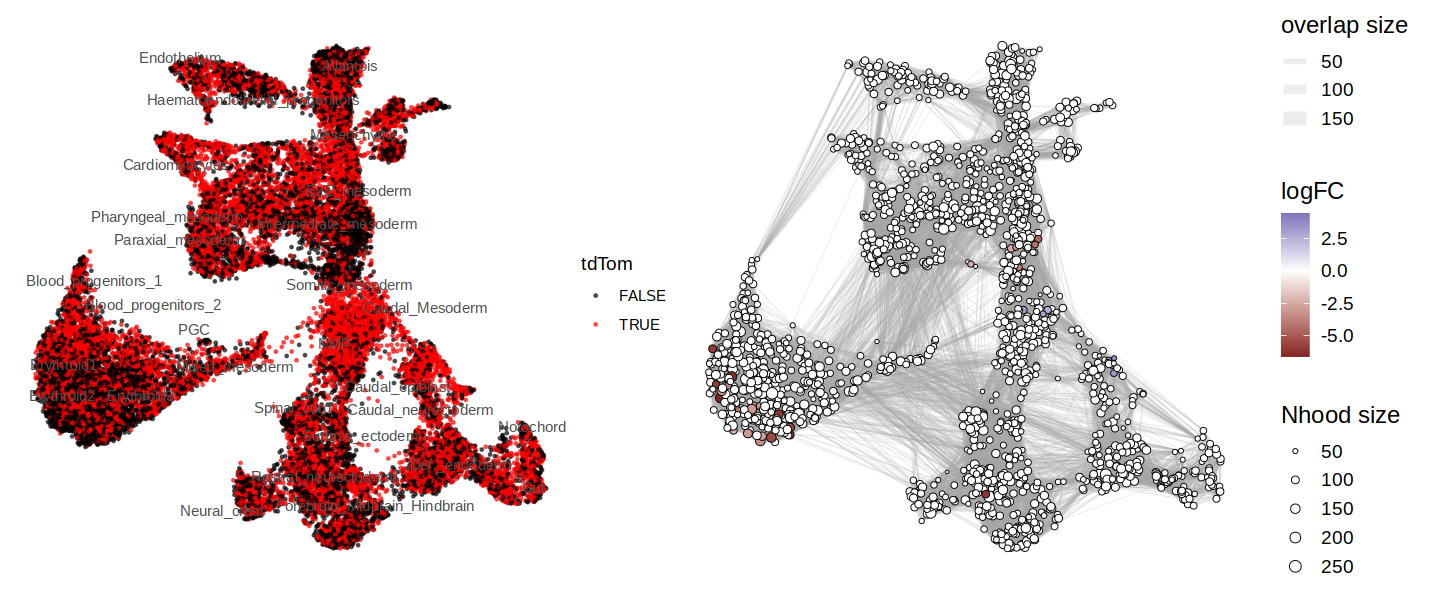

In [45]:
options(repr.plot.width = 12, repr.plot.height=5)

p1 + p2
p3 + p4 

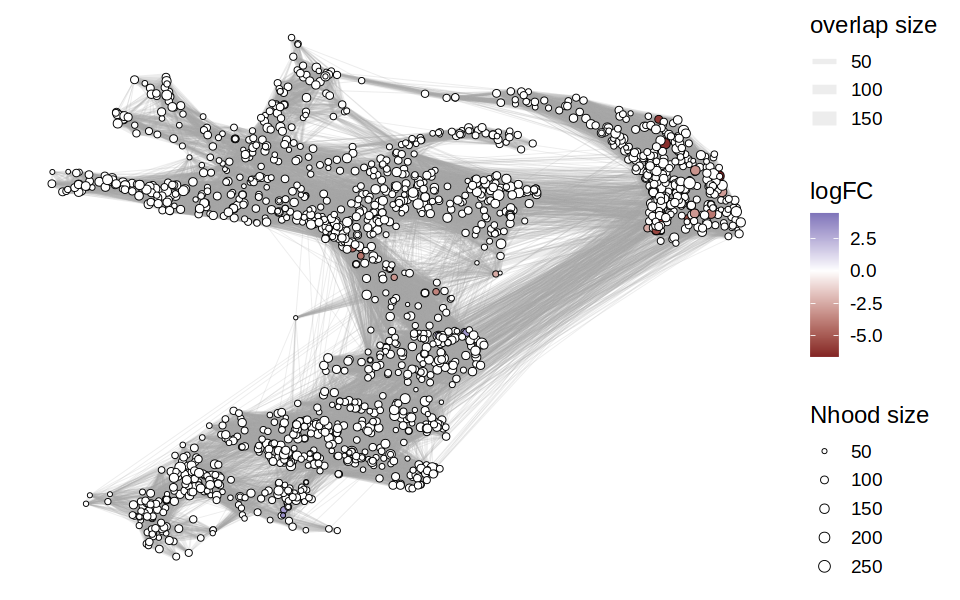

In [46]:
options(repr.plot.width = 8, repr.plot.height=5)
plotNhoodGraphDA(Milo_sce, da_results, layout="UMAP_atlas",alpha=0.05) 

In [47]:
# Find Neighbourhood groups
#da_results <- groupNhoods(Milo_sce, da_results, max.lfc.delta = 0.5, overlap = 20)

# Annotate hoods by celltype
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_extended.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_updated")

# Annotate 'mixed' hoods when there is not one main celltype
da_results$celltype.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype.mapped_mnn)
da_results$celltype_extended.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype_extended.mapped_mnn)
da_results$celltype_updated <- ifelse(da_results$celltype_updated_fraction < 0.4, "Mixed", da_results$celltype_updated)

Converting celltype.mapped_mnn to factor...

Converting celltype_extended.mapped_mnn to factor...

Converting celltype_updated to factor...



In [81]:
fwrite(da_results, file.path(args$outdir, 'da_results.txt.gz'))

In [3]:
da_results = fread(file.path(args$outdir, 'da_results.txt.gz'))

In [4]:
celltype2germlayer = c(
    'Amniotic_ectoderm' = 'ectoderm', 
    'Surface_ectoderm' = 'ectoderm', 
    'Caudal_neurectoderm' = 'ectoderm',
    'Rostral_neurectoderm' = 'ectoderm', 
    'Spinal_cord' = 'ectoderm', 
    'NMP' = 'ectoderm', 
    'Forebrain_Midbrain_Hindbrain' = 'ectoderm', 
    'Neural_crest' = 'ectoderm', 

    'Notochord' = 'endoderm', 
    'Def._endoderm' = 'endoderm', 
    'Gut' = 'endoderm', 

    'PGC' = 'other', 
    'Caudal_epiblast' = 'other', 
    'Mixed' = 'other', 

    'Intermediate_mesoderm' = 'mesoderm', 
    'Nascent_mesoderm' = 'mesoderm',
    'Lateral_plate_mesoderm' = 'mesoderm', 
    'Allantois' = 'mesoderm', 
    'Somitic_mesoderm' = 'mesoderm', 
    'Caudal_Mesoderm' = 'mesoderm', 
    'Mesenchyme' = 'mesoderm', 
    'Pharyngeal_mesoderm' = 'mesoderm', 
    'Paraxial_mesoderm' = 'mesoderm', 
    'Cardiomyocytes' = 'mesoderm', 
    'YS_mesothelium' = 'mesoderm', 
    'Venous_endothelium' = 'mesoderm', 
    'Embryo_proper_endothelium' = 'mesoderm', 
    'Allantois_endothelium' = 'mesoderm', 
    'YS_endothelium' = 'mesoderm', 
    'Blood_progenitors_1' = 'mesoderm', 
    'Blood_progenitors_2' = 'mesoderm',
    'Erythroid' = 'mesoderm'
)

In [12]:
da_results.plot = as.data.table(da_results) %>% copy() %>%
    .[,color := ifelse(SpatialFDR < 0.05, logFC, 0)] %>% .[order(abs(color))] %>% 
    .[,germ_layer := str_to_title(celltype2germlayer[celltype_updated])] %>%
    .[, celltype_updated := factor(celltype_updated, levels = names(celltype2germlayer))] #%>% 
  #  .[germ_layer != 'Ectoderm']

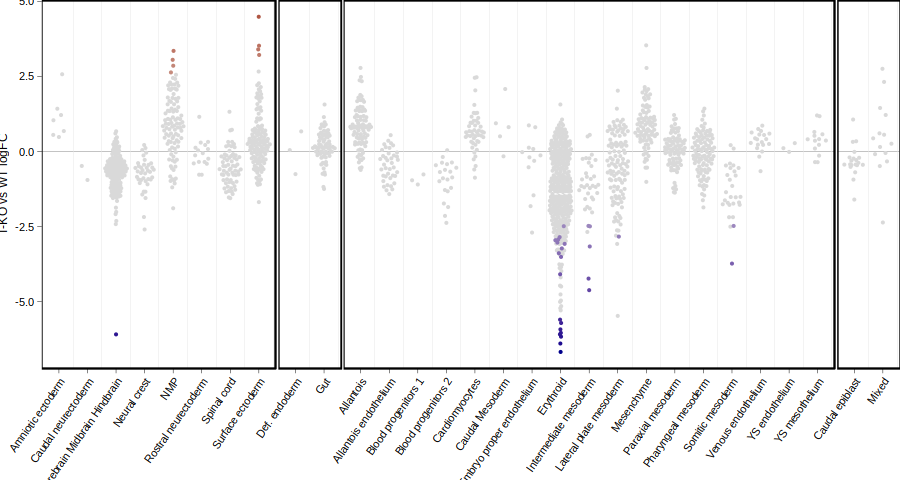

In [13]:
options(repr.plot.width = 7.5, repr.plot.height=4)
p = ggplot(da_results.plot, aes(gsub('_', ' ', celltype_updated), logFC, color=color)) + 
    geom_hline(yintercept = 0, color = 'grey50', linewidth = 0.1) +
    ggbeeswarm::geom_quasirandom(size = 0.1) + 
    geom_vline(xintercept=seq(1.5, 20, 1), color = 'grey90', linewidth = 0.1) + 
    scale_color_gradient2(low='darkblue', mid='grey85', high='darkred', name = 'LogFC') + 
    facet_grid(cols = vars(germ_layer), scales='free', space='free') + 
    guides(colour = guide_colourbar(
         barwidth = 0.5, barheight = 2.5,
        frame.colour = "black", 
        ticks.colour = "black"
    )) + 
    # ggtitle('Differential Abundance') + 
    ylab('T-KO vs WT logFC') + 
    theme_bw() + 
    theme(axis.text.x = element_text(size=6, color = 'black', angle = 55, hjust = 1),
          axis.text.y = element_text(size = 6, color = 'black'),
          axis.ticks=element_line(linewidth=0.1, color = 'black'),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size=7, color='black', vjust = 1.5),
          legend.text = element_text(size=6, color='black'),
          legend.title = element_text(size=7, color='black'),
          plot.title = element_text(size=8, color='black', hjust = 0.5, vjust = -1),
          panel.border = element_rect(color='black', linewidth=0.5),
          panel.spacing = unit(0.5, "mm"),
          legend.position = 'none', # Position legend outside the plot (right and center vertically)
          legend.justification = c("left", "center"), # Justify legend to the center vertically and to the left horizontally
          legend.box.margin = margin(0, 0, 0, 0), # Adjust the margins around the legend box
          legend.margin = margin(0, 0, 0, 0), # Adjust the margins inside the legend box
          plot.margin = margin(0,0,0,0),
          panel.grid = element_blank(), 
          strip.background=element_blank(),
          strip.text.x = element_blank()) #_text(size=15, color='black', angle=0, hjust=0))
p
ggsave(file.path(io$basedir, 'figures/differential_abundance.pdf'), 
       plot = p, 
       width = 90, height = 50, units = "mm")

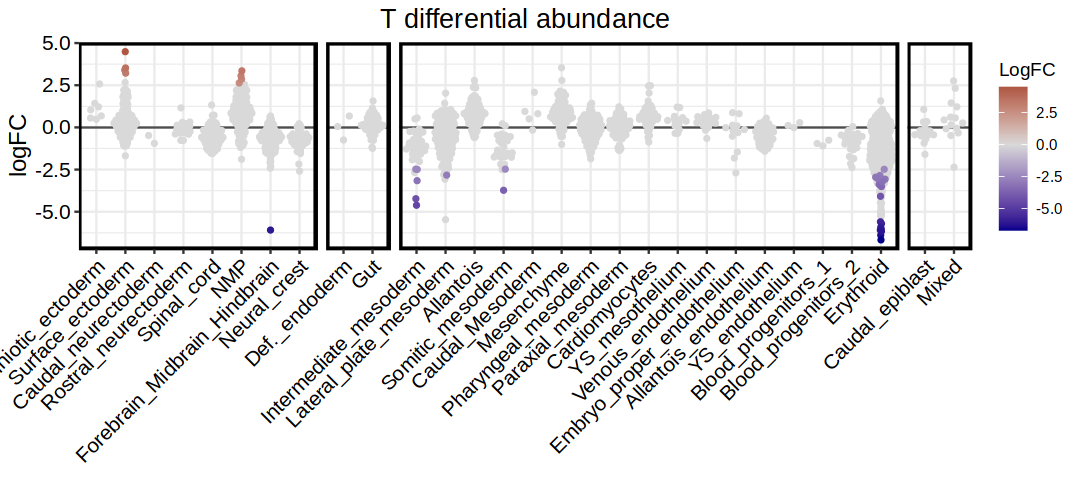

In [80]:
options(repr.plot.width = 9, repr.plot.height=4)
da_results.plot = da_results.plot[order(-SpatialFDR)]
ggplot(da_results.plot, aes(celltype_updated, logFC, color=color)) + 
    geom_hline(yintercept = 0, color = 'grey30') + 
    ggbeeswarm::geom_quasirandom(size = 1) + 
    scale_color_gradient2(low='darkblue', mid='grey85', high='darkred', name = 'LogFC') + 
    facet_grid(cols = vars(germ_layer), scales='free', space='free') + 
    ggtitle('T differential abundance') + 
    theme_bw() + 
    theme(axis.text = element_text(size=12, color='black'),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size=14, color='black'),
          panel.border = element_rect(color='black', linewidth=1.3),
          plot.title = element_text(size = 16, hjust = 0.5),
          legend.position='right',
          strip.background=element_blank(),
          strip.text.x = element_blank()) #_text(size=15, color='black', angle=0, hjust=0))